In [32]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

from skimage import feature, data, color
from glob import glob # Used to easily find file paths
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
img = cv2.imread('all-mias/mdb005.pgm', cv2.IMREAD_GRAYSCALE)
# print(img.shape, img.dtype)
# img.max()
# plt.imshow(img, cmap='gray')

n_img = ((img - img.min()) / (img.max() - img.min()) * 255) # Normalazing the image 
P = 8
R = 1
method = 'uniform'
LBP = feature.local_binary_pattern(n_img, P, R, method)
print(LBP)

[[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]


8.0


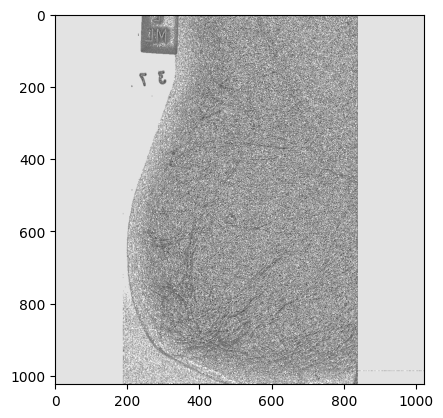

In [42]:
x, y = 500, 145
print(LBP[x, y])

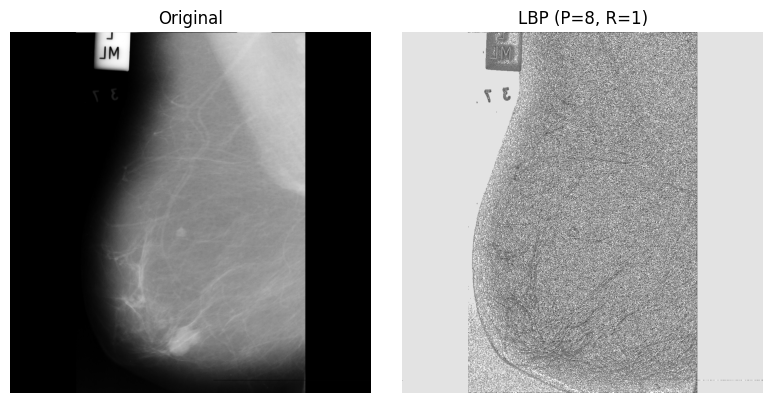

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(n_img, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(LBP, cmap='gray')
axes[1].set_title(f"LBP (P={P}, R={R})")
axes[1].axis('off')
plt.tight_layout()
plt.show()

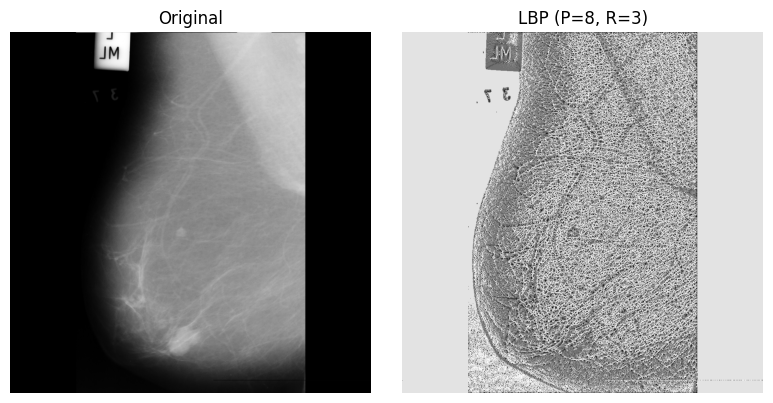

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(n_img, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(LBP, cmap='gray')
axes[1].set_title(f"LBP (P={P}, R={R})")
axes[1].axis('off')
plt.tight_layout()
plt.show()